<a href="https://colab.research.google.com/github/niteshkumartiwari/My-Notebook-Collection/blob/master/Problem_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
!wget -O train.csv "https://www.dropbox.com/sh/ti9ta6mzdx56x1f/AAA-JbNaAHzMs_Xs3xwu7K53a/Training.csv?dl=0"

In [0]:
!wget -O test.csv "https://www.dropbox.com/sh/ti9ta6mzdx56x1f/AACZjJ4lHrh_RTDaCsQ5HeKia/Testing.csv?dl=0"

In [0]:
!wget -O sample.csv "https://www.dropbox.com/sh/ti9ta6mzdx56x1f/AACGdX2acMpsNpia_7FN_2c9a/Sample%20Submission.csv?dl=0"

In [6]:
!ls

sample.csv  sample_data  test.csv  train.csv


#DataSet v1 Analysis

In [0]:
df=pd.read_csv('train.csv')

In [0]:
df.head()

,Cycle,Type,EndTime,Time,Values
0,2,2,3490.0,101.0,20.402
1,2,2,3490.0,102.0,20.402
2,2,2,3490.0,103.0,20.402
3,2,2,3490.0,104.0,20.402
4,2,2,3490.0,105.0,20.402


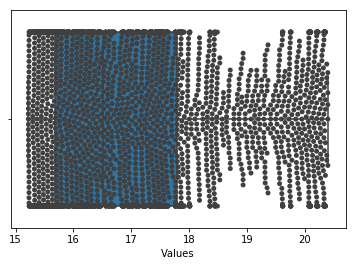

In [0]:
sns.boxplot("Values", data=df[df['Cycle']==2])
sns.swarmplot("Values", data=df[df['Cycle']==2], color=".25")

(**To-Do**)
*We can clip off the training data set till 1800. as req in test data*

In [0]:
def makeFeatureDataset(df):
  cycle_set=df['Cycle'].unique()
  
  data=[]
  for i in range(len(cycle_set)):
    val=[]
    df_temp=df[df['Cycle']==cycle_set[i]]
    #val.append(cycle_set[i])
    val.append(float('%.3f'%(df_temp['Values'].mean())))
    val.append(float('%.3f'%(df_temp['Values'].var())))
    val.append(float('%.3f'%(df_temp['Values'].std())))
    val.append(float('%.3f'%(df_temp['Values'].quantile(0.25))))
    val.append(float('%.3f'%(df_temp['Values'].quantile(0.75))))
    val.append(df_temp.iloc[0]['EndTime'])

    data.append(val)
    
  col=['Mean', 'Variance', 'Std-Dev', '25-Quartile', '75-Quartile', 'EndTime']
  df_feature = pd.DataFrame(data, columns = col)
    
  return df_feature

In [0]:
df_feature= makeFeatureDataset(df)

In [0]:
df_feature['IQR']=df_feature['75-Quartile']-df_feature['25-Quartile']

In [12]:
df_feature.head()

,Mean,Variance,Std-Dev,25-Quartile,75-Quartile,EndTime,IQR
0,16.970,2.257,1.502,15.677,17.795,3490.0,2.118
1,18.490,1.851,1.360,17.133,19.910,2556.0,2.777
2,15.356,8.570,2.928,12.124,18.067,3909.0,5.943
3,18.716,2.402,1.550,16.947,20.182,2113.0,3.235
4,16.926,5.426,2.329,14.253,19.002,2978.0,4.749


In [13]:
len(df_feature)

40

#Analysis of Each Feature with #EndTime

## 1.Finding PairWise RelationShip

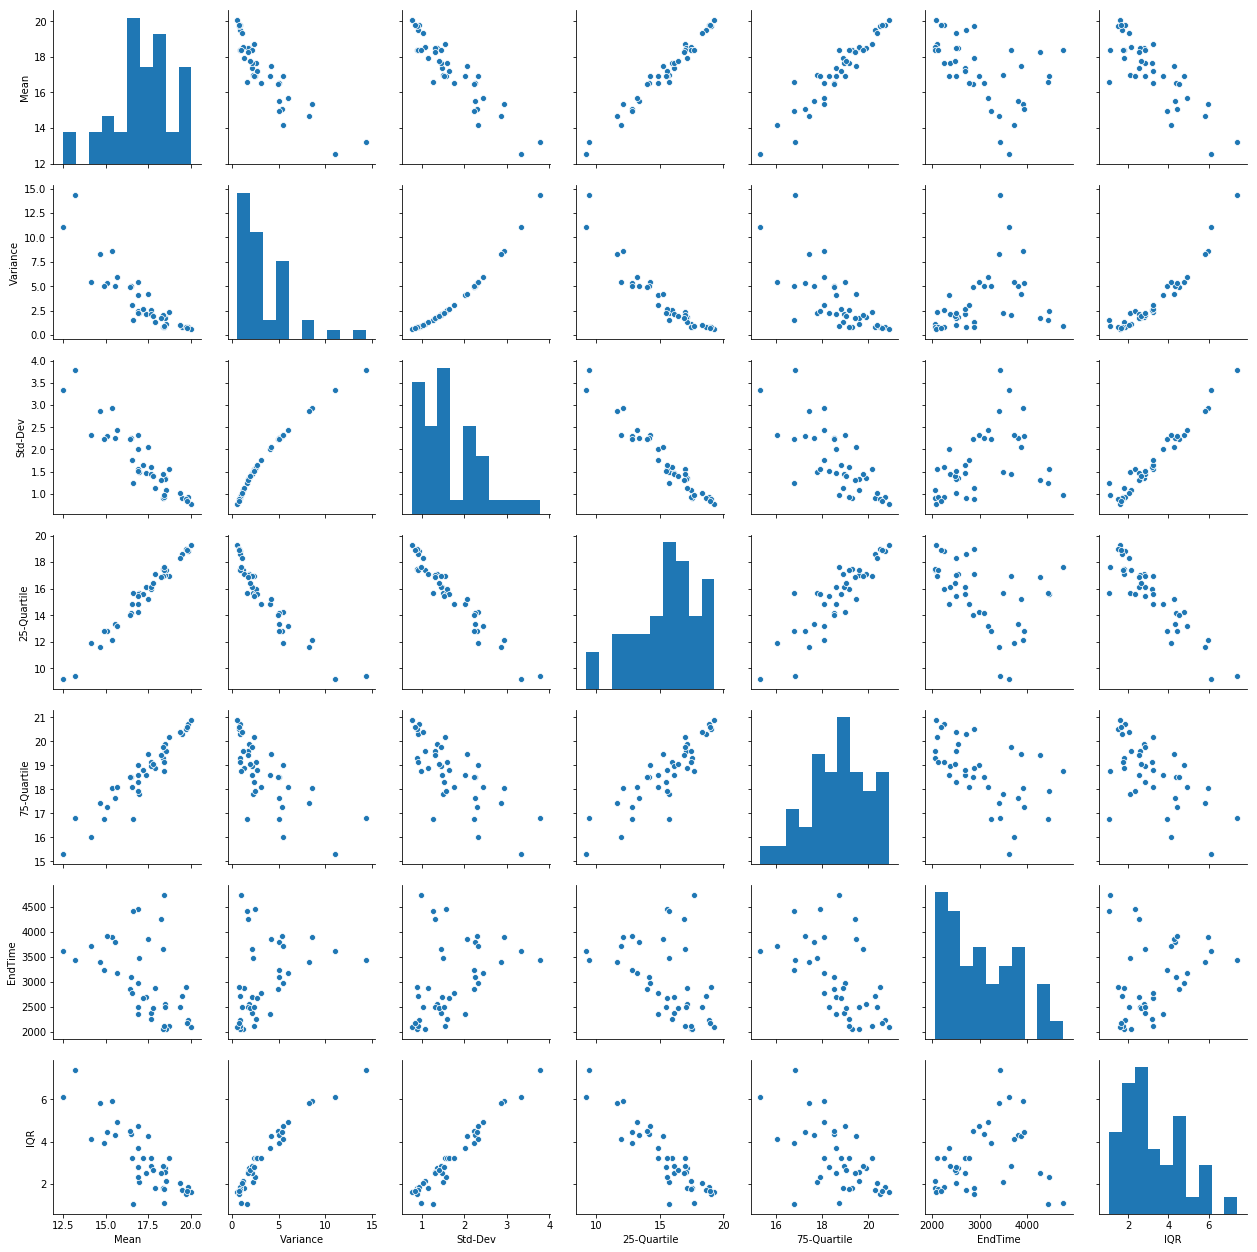

In [14]:
sns.pairplot(df_feature);

## 2. Generating a Correlation Matrix between features

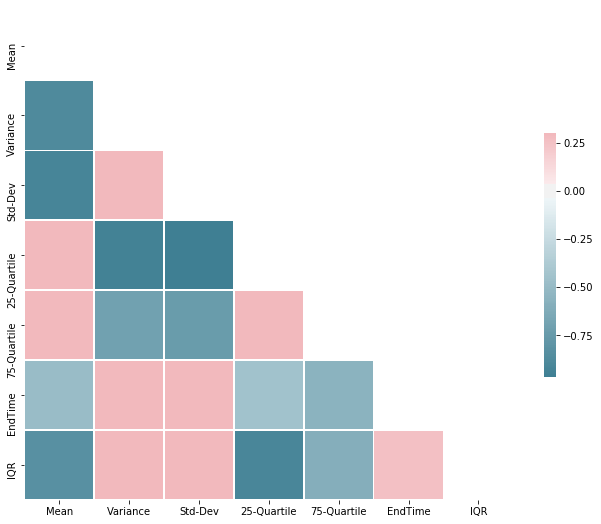

In [15]:
# Compute the correlation matrix
corr = df_feature.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

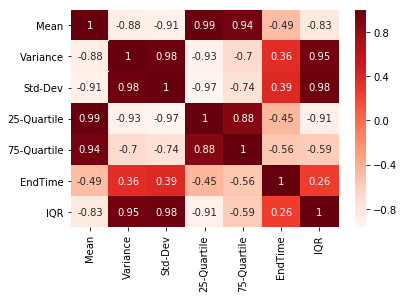

In [16]:
#Using Pearson Correlation
sns.heatmap(corr, annot=True, cmap=plt.cm.Reds)

# Feature Selection

## 1. Filter Method

We feed all the possible features to the model at first. We check the performance of the model and then iteratively remove the worst performing features one by one till the overall performance of the model comes in acceptable range.

The performance metric used here to evaluate feature performance is pvalue. If the pvalue is above 0.05 then we remove the feature, else we keep it.

We will first run one iteration here just to get an idea of the concept and then we will run the same code in a loop, which will give the final set of features. Here we are using OLS model which stands for “Ordinary Least Squares”. This model is used for performing linear regression.

In [17]:
#Correlation with output variable
cor_target = abs(corr["EndTime"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.4]
relevant_features

Mean           0.486528
25-Quartile    0.445167
75-Quartile    0.559713
EndTime        1.000000
Name: EndTime, dtype: float64

In [18]:
#Checking Internal Feature Correlation
print(df_feature[["25-Quartile","75-Quartile"]].corr())
print(df_feature[["25-Quartile","Mean"]].corr())

             25-Quartile  75-Quartile
25-Quartile     1.000000     0.877172
75-Quartile     0.877172     1.000000
             25-Quartile      Mean
25-Quartile     1.000000  0.985775
Mean            0.985775  1.000000


1. *25- Quartile and Mean are strictly related. Need to drop one before predicting.*
2. *We can combine 25Quartile and 75Quartile into one feature i.e. (75Q-25Q) that will be interQuartile Range.*

## 2. Wrapper Method

A wrapper method needs one machine learning algorithm and uses its performance as evaluation criteria. This means, you feed the features to the selected Machine Learning algorithm and based on the model performance you add/remove the features. This is an iterative and computationally expensive process but it is more accurate than the filter method.

There are different wrapper methods such as Backward Elimination, Forward Selection, Bidirectional Elimination and RFE. We will discuss Backward Elimination and RFE here.

### i. Backward Elimination

We check the performance of the model and then iteratively remove the worst performing features one by one till the overall performance of the model comes in acceptable range.

The performance metric used here to evaluate feature performance is pvalue. If the pvalue is above 0.05 then we remove the feature, else we keep it.

We will first run one iteration here just to get an idea of the concept and then we will run the same code in a loop, which will give the final set of features. Here we are using OLS model which stands for “Ordinary Least Squares”. This model is used for performing linear regression.

In [0]:
X=df_feature[['Mean','Variance','Std-Dev','25-Quartile','75-Quartile','IQR']]
Y=df_feature[['EndTime']]

In [20]:
#install if sm throws error
!pip install statsmodels==0.10.0rc2 --pre

      Successfully uninstalled statsmodels-0.10.0


In [21]:
import statsmodels.api as sm

#Adding constant column of ones, mandatory for sm.OLS model
X_1 = sm.add_constant(X)
#Fitting sm.OLS model
model = sm.OLS(Y,X_1).fit()
model.pvalues

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


const          0.334244
Mean           0.931385
Variance       0.272889
Std-Dev        0.003623
25-Quartile    0.293670
75-Quartile    0.464863
IQR            0.000963
dtype: float64

In [22]:
#Backward Elimination
cols = list(X.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(Y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

['Std-Dev', '25-Quartile', '75-Quartile', 'IQR']


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


###ii. Recursive Feature Elimination

The Recursive Feature Elimination (RFE) method works by recursively removing attributes and building a model on those attributes that remain. It uses accuracy metric to rank the feature according to their importance. The RFE method takes the model to be used and the number of required features as input. It then gives the ranking of all the variables, 1 being most important. It also gives its support, True being relevant feature and False being irrelevant feature.

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, 2)
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,Y)  
#Fitting the data to model
model.fit(X_rfe,Y)
print(rfe.support_)
print(rfe.ranking_)
print(X.columns)

[False False False  True  True False]
[5 4 3 1 1 2]
Index(['Mean', 'Variance', 'Std-Dev', '25-Quartile', '75-Quartile', 'IQR'], dtype='object')


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [26]:
from sklearn.model_selection import train_test_split

#no of features
nof_list=np.arange(1,5)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 3
Score with 3 features: 0.735246


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

In [28]:
cols = list(X.columns)
model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, 4)             
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,Y)  
#Fitting the data to model
model.fit(X_rfe,Y)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)


Index(['Std-Dev', '25-Quartile', '75-Quartile', 'IQR'], dtype='object')


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### iii. Embedded Method

Embedded methods are iterative in a sense that takes care of each iteration of the model training process and carefully extract those features which contribute the most to the training for a particular iteration. Regularization methods are the most commonly used embedded methods which penalize a feature given a coefficient threshold.
Here we will do feature selection using Lasso regularization. If the feature is irrelevant, lasso penalizes it’s coefficient and make it 0. Hence the features with coefficient = 0 are removed and the rest are taken.

In [0]:
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

reg = LassoCV()
reg.fit(X, Y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,Y))
coef = pd.Series(reg.coef_, index = X.columns)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Text(0.5, 1.0, 'Feature importance using Lasso Model')

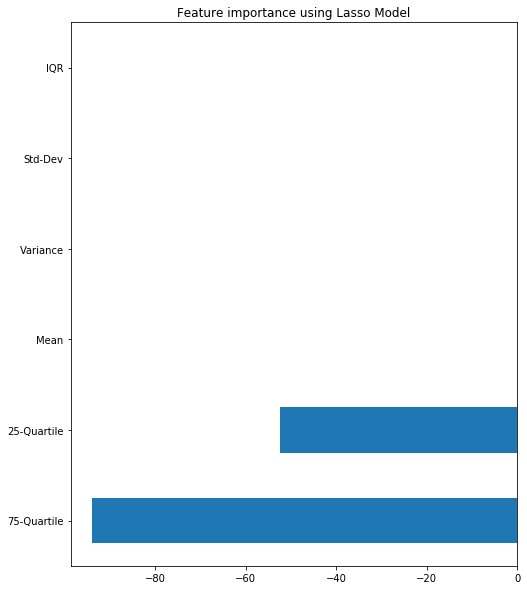

In [30]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

# Modeling

In [31]:
df_feature.head()

,Mean,Variance,Std-Dev,25-Quartile,75-Quartile,EndTime,IQR
0,16.970,2.257,1.502,15.677,17.795,3490.0,2.118
1,18.490,1.851,1.360,17.133,19.910,2556.0,2.777
2,15.356,8.570,2.928,12.124,18.067,3909.0,5.943
3,18.716,2.402,1.550,16.947,20.182,2113.0,3.235
4,16.926,5.426,2.329,14.253,19.002,2978.0,4.749


In [32]:
df_feature.dtypes

Mean           float64
Variance       float64
Std-Dev        float64
25-Quartile    float64
75-Quartile    float64
EndTime        float64
IQR            float64
dtype: object

In [33]:
X.head()

,Mean,Variance,Std-Dev,25-Quartile,75-Quartile,IQR
0,16.970,2.257,1.502,15.677,17.795,2.118
1,18.490,1.851,1.360,17.133,19.910,2.777
2,15.356,8.570,2.928,12.124,18.067,5.943
3,18.716,2.402,1.550,16.947,20.182,3.235
4,16.926,5.426,2.329,14.253,19.002,4.749


In [34]:
Y.head()

,EndTime
0,3490.0
1,2556.0
2,3909.0
3,2113.0
4,2978.0


In [0]:
#Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.1, random_state = 0)

## Trying Various Models

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn import model_selection, tree, linear_model
from sklearn.metrics import mean_absolute_error
import xgboost

### 1. Linear regression

In [245]:
linear_regr = linear_model.LinearRegression(n_jobs=100,normalize=True)
linear_regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=100, normalize=True)

In [246]:
linear_regr.score(X_test,y_test)

0.5160242074337283

In [247]:
predictions = linear_regr.predict(X_test)
print(mean_absolute_error(y_test,predictions))

328.79300054318696


### 2. XGBoost

In [0]:
# Let's try XGboost algorithm to see if we can get better results
xgb_regr = xgboost.XGBRegressor(n_estimators=500,booster='gbtree',objective = "reg:linear", learning_rate=0.06, gamma=0, subsample=0.5,
                           colsample_bytree=1, max_depth=7)

In [300]:
xgb_regr.fit(X_train,y_train,eval_metric='mae')

[19:04:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.06, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.5, verbosity=1)

In [301]:
predictions = xgb_regr.predict(X_test)
print(mean_absolute_error(y_test,predictions))

281.3111572265625


In [302]:
predictions

array([2856.0864, 2241.0437, 2390.5176, 2964.1428], dtype=float32)

In [303]:
y_test

,EndTime
22,3664.0
20,2246.0
25,2092.0
4,2978.0


### Cross validation xgboost

In [0]:
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import confusion_matrix, mean_squared_error
import xgboost as xgb

First, we tune the max_depth and min_child_weight parameters on a wide range of values. Later, we will refine these two choices with a smaller grid. Note that if you are running this in a Jupyter notebook, you can see the training process in your bash window. We will use the parameters dict to store the latest parameter values, and the scores vector to store the MSE values

In [264]:
objective = "reg:linear"
seed = 100
n_estimators = 100
learning_rate = 0.1
gamma = 0.1
subsample = 0.8
colsample_bytree = 0.8
reg_alpha = 1
reg_lambda = 1
silent = False

parameters = {}
parameters['objective'] = objective
parameters['seed'] = seed
parameters['n_estimators'] = n_estimators
parameters['learning_rate'] = learning_rate
parameters['gamma'] = gamma
parameters['colsample_bytree'] = colsample_bytree
parameters['reg_alpha'] = reg_alpha
parameters['reg_lambda'] = reg_lambda
parameters['silent'] = silent

scores = []

cv_params = {'max_depth': [2,4,6,8],
             'min_child_weight': [1,3,5,7]
            }

gbm = GridSearchCV(xgb.XGBRegressor(
                                        objective = objective,
                                        seed = seed,
                                        n_estimators = n_estimators,
                                        learning_rate = learning_rate,
                                        gamma = gamma,
                                        subsample = subsample,
                                        colsample_bytree = colsample_bytree,
                                        reg_alpha = reg_alpha,
                                        reg_lambda = reg_lambda,
                                        silent = silent

                                    ),
                    
                    param_grid = cv_params,
                    iid = False,
                    scoring = "neg_mean_absolute_error",
                    cv = 5,
                    verbose = True
)

gbm.fit(X_train,y_train)
print (gbm.cv_results_)
print ("Best parameters %s" %gbm.best_params_)
print ("Best score %s" %gbm.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[18:57:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:57:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:57:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:57:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:57:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:57:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:57:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:57:24] WARNING: /workspace/src/objective/regre

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[18:57:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:57:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:57:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:57:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:57:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:57:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:57:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:57:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    1.6s finished


Refine with a smaller grid of values based on best values from the big grid above

In [265]:
max_depth = gbm.best_params_['max_depth']
min_child_weight = gbm.best_params_['min_child_weight']
parameters['max_depth'] = max_depth
parameters['min_child_weight'] = min_child_weight
scores.append(gbm.best_score_)

cv_params = {'max_depth': [max_depth-1, max_depth, max_depth+1], 
             'min_child_weight': [min_child_weight-1, min_child_weight-0.5, min_child_weight, min_child_weight+0.5, min_child_weight+1]
            }

gbm = GridSearchCV(xgb.XGBRegressor(
                                        objective = objective,
                                        seed = seed,
                                        n_estimators = n_estimators,
                                        learning_rate = learning_rate,
                                        gamma = gamma,
                                        subsample = subsample,
                                        colsample_bytree = colsample_bytree,
                                        reg_alpha = reg_alpha,
                                        reg_lambda = reg_lambda,
                                        silent = silent

                                    ),
                   
                    param_grid = cv_params,
                    iid = False,
                    scoring = "neg_mean_absolute_error",
                    cv = 5,
                    verbose = True
)

gbm.fit(X_train,y_train)
print (gbm.cv_results_)
print ("Best parameters %s" %gbm.best_params_)
print ("Best score %s" %gbm.best_score_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[18:57:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:57:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:57:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:57:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:57:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:57:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:57:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:57:35] WARNING: /workspace/src/objective/regre

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[18:57:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:57:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:57:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:57:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:57:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:57:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:57:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:57:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    1.5s finished


Set max_depth and min_child_weight before tuning gamma parameter

In [266]:
max_depth = gbm.best_params_['max_depth']
min_child_weight = gbm.best_params_['min_child_weight']
parameters['max_depth'] = max_depth
parameters['min_child_weight'] = min_child_weight
scores.append(gbm.best_score_)

cv_params = {'gamma': [i/10.0 for i in range(1,10,2)]}

gbm = GridSearchCV(xgb.XGBRegressor(
                                        objective = objective,
                                        seed = seed,
                                        n_estimators = n_estimators,
                                        max_depth = max_depth,
                                        min_child_weight = min_child_weight,
                                        learning_rate = learning_rate,
                                        subsample = subsample,
                                        colsample_bytree = colsample_bytree,
                                        reg_alpha = reg_alpha,
                                        reg_lambda = reg_lambda,
                                        silent = silent

                                    ),
                   
                    param_grid = cv_params,
                    iid = False,
                    scoring = "neg_mean_absolute_error",
                    cv = 5,
                    verbose = True
)

gbm.fit(X_train,y_train)
print (gbm.cv_results_)
print ("Best parameters %s" %gbm.best_params_)
print ("Best score %s" %gbm.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[18:57:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:57:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:57:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:57:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:57:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:57:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:57:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:57:54] WARNING: /workspace/src/objective/regres

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[18:57:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:57:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:57:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:57:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:57:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:57:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:57:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:57:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.5s finished


Set the gamma parameter and tune the subsample and colsample_bytree parameters next. We will look at 10% intervals from 60% to 100% for both subsample and colsample_bytree

In [267]:
gamma = gbm.best_params_['gamma']
parameters['gamma'] = gamma
scores.append(gbm.best_score_)

cv_params = {'subsample': [i/10.0 for i in range(6,11)],
             'colsample_bytree': [i/10.0 for i in range(6,11)]
            }

gbm = GridSearchCV(xgb.XGBRegressor(
                                        objective = objective,
                                        seed = seed,
                                        n_estimators = n_estimators,
                                        max_depth = max_depth,
                                        min_child_weight = min_child_weight,
                                        learning_rate = learning_rate,
                                        gamma = gamma,
                                        reg_alpha = reg_alpha,
                                        reg_lambda = reg_lambda,
                                        silent = silent

                                    ),
                   
                    param_grid = cv_params,
                    iid = False,
                    scoring = "neg_mean_absolute_error",
                    cv = 5,
                    verbose = True
)

gbm.fit(X_train,y_train)
print (gbm.cv_results_)
print ("Best parameters %s" %gbm.best_params_)
print ("Best score %s" %gbm.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[18:58:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:58:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:58:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:58:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:58:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:58:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:58:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:58:02] WARNING: /workspace/src/objective/regr

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[18:58:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:58:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:58:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:58:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:58:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:58:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:58:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:58:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    2.4s finished


Retune with a smaller grid of values based on best values from the big grid above. Look at 5% intervals in some range around the best values found previously

In [268]:
subsample = gbm.best_params_['subsample']
colsample_bytree = gbm.best_params_['colsample_bytree']
parameters['subsample'] = subsample
parameters['colsample_bytree'] = colsample_bytree
scores.append(gbm.best_score_)

cv_params = {'subsample': [i/100.0 for i in range(int((subsample-0.1)*100.0), min(int((subsample+0.1)*100),105) , 5)],
             'colsample_bytree': [i/100.0 for i in range(int((colsample_bytree-0.1)*100.0), min(int((subsample+0.1)*100),105), 5)]
            }

gbm = GridSearchCV(xgb.XGBRegressor(
                                        objective = objective,
                                        seed = seed,
                                        n_estimators = n_estimators,
                                        max_depth = max_depth,
                                        min_child_weight = min_child_weight,
                                        learning_rate = learning_rate,
                                        gamma = gamma,
                                        reg_alpha = reg_alpha,
                                        reg_lambda = reg_lambda,
                                        silent = silent

                                    ),
                   
                    param_grid = cv_params,
                    iid = False,
                    scoring = "neg_mean_absolute_error",
                    cv = 5,
                    verbose = True
)

gbm.fit(X_train,y_train)
print (gbm.cv_results_)
print ("Best parameters %s" %gbm.best_params_)
print ("Best score %s" %gbm.best_score_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[18:58:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:58:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:58:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:58:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:58:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:58:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:58:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:58:08] WARNING: /workspace/src/objective/regre

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[18:58:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:58:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:58:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:58:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:58:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:58:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:58:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:58:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    1.5s finished


Set the colsample_bytree and subsample parameters before tuning reg_alpha and reg_lambda parameters. reg_alpha controls L1 regularisation and reg_lambda controls L2 regularisation

In [269]:
colsample_bytree = gbm.best_params_['colsample_bytree']
subsample = gbm.best_params_['subsample']
parameters['colsample_bytree'] = colsample_bytree
parameters['subsample'] = subsample
scores.append(gbm.best_score_)

cv_params = {'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100], 
             'reg_lambda': [1e-5, 1e-2, 0.1, 1, 100]
            }

gbm = GridSearchCV(xgb.XGBRegressor(
                                        objective = objective,
                                        seed = seed,
                                        n_estimators = n_estimators,
                                        max_depth = max_depth,
                                        min_child_weight = min_child_weight,
                                        learning_rate = learning_rate,
                                        gamma = gamma,
                                        colsample_bytree = colsample_bytree,
                                        subsample = subsample,
                                        silent = silent

                                    ),
                   
                    param_grid = cv_params,
                    iid = False,
                    scoring = "neg_mean_absolute_error",
                    cv = 5,
                    verbose = True
)

gbm.fit(X_train,y_train)
print (gbm.cv_results_)
print ("Best parameters %s" %gbm.best_params_)
print ("Best score %s" %gbm.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[18:58:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:58:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:58:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:58:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:58:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:58:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:58:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:58:20] WARNING: /workspace/src/objective/regr

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[18:58:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:58:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:58:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:58:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:58:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:58:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:58:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:58:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    2.5s finished


Refine parameters on a smaller grid. Look at a smaller grid around the best values found previously

In [270]:
reg_alpha = gbm.best_params_['reg_alpha']
reg_lambda = gbm.best_params_['reg_lambda']
parameters['reg_alpha'] = reg_alpha
parameters['reg_lambda'] = reg_lambda
scores.append(gbm.best_score_)

cv_params = {'reg_lambda': [reg_alpha*0.2, reg_alpha*0.5, reg_alpha, reg_alpha*2, reg_alpha*5], 
             'reg_alpha': [reg_lambda*0.2, reg_lambda*0.5, reg_lambda, reg_lambda*2, reg_lambda*5]
            }

gbm = GridSearchCV(xgb.XGBRegressor(
                                        objective = objective,
                                        seed = seed,
                                        n_estimators = n_estimators,
                                        max_depth = max_depth,
                                        min_child_weight = min_child_weight,
                                        learning_rate = learning_rate,
                                        gamma = gamma,
                                        colsample_bytree = colsample_bytree,
                                        subsample = subsample,
                                        silent = silent

                                    ),
                   
                    param_grid = cv_params,
                    iid = False,
                    scoring = "neg_mean_absolute_error",
                    cv = 5,
                    verbose = True
)

gbm.fit(X_train,y_train)
print (gbm.cv_results_)
print ("Best parameters %s" %gbm.best_params_)
print ("Best score %s" %gbm.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[18:58:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:58:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:58:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:58:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:58:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:58:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:58:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:58:27] WARNING: /workspace/src/objective/regr

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[18:58:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:58:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:58:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:58:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:58:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:58:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:58:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:58:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    2.5s finished


## Set regularisation parameters before increasing the number of trees and reducing the learning rate

In [0]:
reg_alpha = gbm.best_params_['reg_alpha']
reg_lambda = gbm.best_params_['reg_lambda']
parameters['reg_alpha'] = reg_alpha
parameters['reg_lambda'] = reg_lambda
scores.append(gbm.best_score_)

## Print final parameters used and scores obtained

Importantly, ensure scores are increasing with each iteration. For the above implementation, the negative MSE objective function should be increasing in order to minimise MSE

In [272]:
print (parameters)
print (scores)

{'objective': 'reg:linear', 'seed': 100, 'n_estimators': 100, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.85, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'silent': False, 'max_depth': 2, 'min_child_weight': 1.5, 'subsample': 1.0}
[-442.6899164202008, -438.2178312848772, -438.2178312848772, -413.93037662527894, -413.93037662527894, -408.3780721121651, -408.3780721121651]


## Create XGBoost's DMatrix

We will use this for finding the best tree via cross validation, and in the final XGBoost model

In [0]:
trainDMat = xgb.DMatrix(data = X_train, label = y_train)
testDMat = xgb.DMatrix(data = X_test, label = y_test)

## Find best tree

Lower the learning_rate and set a large num_boost_round hyperparameter to ensure convergence. If convergence is slow, retry with a slightly higher learning rate (e.g. 0.075 instead of 0.05)

In [290]:
learning_rate = 0.05
parameters['eta'] = learning_rate

num_boost_round = 3000
early_stopping_rounds = 20

xgbCV = xgb.cv(
    params = parameters, 
    dtrain = trainDMat, 
    num_boost_round = num_boost_round,
    nfold = 10,
    metrics = {'mae'},
    early_stopping_rounds = early_stopping_rounds,
    verbose_eval = True,
    seed = seed     
)


[19:03:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:03:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:03:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:03:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:03:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:03:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:03:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:03:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

## Finalise XGBoost model

Produce the final booster object using the best tree from our cross validation

In [291]:
num_boost_round = len(xgbCV)
parameters['eval_metric'] = 'mae'

xgbFinal = xgb.train(
    params = parameters, 
    dtrain = trainDMat, 
    num_boost_round = num_boost_round,
    evals = [(trainDMat, 'train'), 
             (testDMat, 'eval')]
)

[19:03:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-mae:2755.42	eval-mae:2480.21
[1]	train-mae:2482.37	eval-mae:2244.62
[2]	train-mae:2237.3	eval-mae:1997.3
[3]	train-mae:2016.43	eval-mae:1774.22
[4]	train-mae:1817.09	eval-mae:1604.23
[5]	train-mae:1637.67	eval-mae:1449.98
[6]	train-mae:1475.74	eval-mae:1319.66
[7]	train-mae:1329.57	eval-mae:1207.07
[8]	train-mae:1197.88	eval-mae:1105.65
[9]	train-mae:1079.64	eval-mae:1006.67
[10]	train-mae:972.815	eval-mae:908.035
[11]	train-mae:876.805	eval-mae:828.387
[12]	train-mae:789.971	eval-mae:765.726
[13]	train-mae:711.739	eval-mae:709.283
[14]	train-mae:641.542	eval-mae:645.46
[15]	train-mae:578.094	eval-mae:587.93
[16]	train-mae:523.923	eval-mae:548.311
[17]	train-mae:476.983	eval-mae:501.778
[18]	train-mae:440.124	eval-mae:452.5
[19]	train-mae:409.477	eval-mae:434.965
[20]	train-mae:382.861	eval-mae:417.823
[21]	train-mae:358.903	eval-mae:404.675
[22]	trai

## Feature importance plot

Plot the feature importance plot to check whether this is making sense before checking optimal parameters and loss function progression

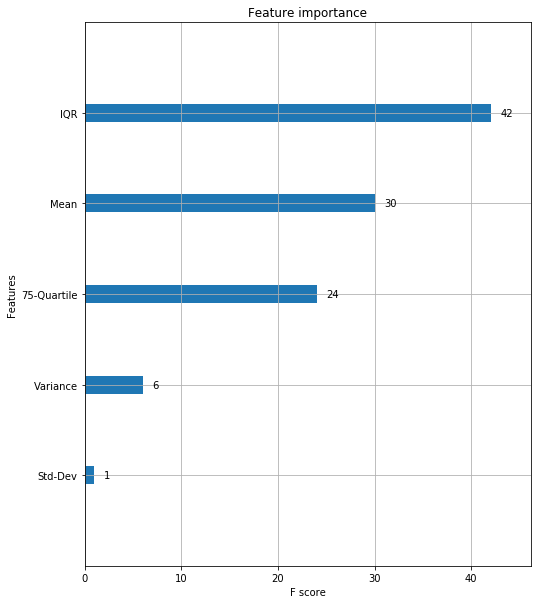

In [292]:
xgb.plot_importance(xgbFinal)

## Produce predictions for train and test sets before measuring accuracy

Calculate predictions for both train and test sets, and then calculate MSE and RMSE for both datasets

In [0]:
xgbFinal_train_preds = xgbFinal.predict(xgb.DMatrix(X_train))
xgbFinal_test_preds = xgbFinal.predict(xgb.DMatrix(X_test))

In [294]:
print(xgbFinal_train_preds.shape)
print(xgbFinal_test_preds.shape)

(36,)
(4,)


In [295]:
print ("\nModel Report")
print ("MAE Train : %f" % mean_absolute_error(y_train, xgbFinal_train_preds))
print ("MAE Test: %f" % mean_absolute_error(y_test, xgbFinal_test_preds))


Model Report
MAE Train : 182.572179
MAE Test: 416.460693


# Predicting

In [0]:
df_test=pd.read_csv('test.csv')

In [305]:
df_test.head()

,Cycle,Type,Time,Values
0,100,2,101,20.456
1,100,2,102,20.456
2,100,2,103,20.456
3,100,2,104,20.448
4,100,2,105,20.448


In [0]:
def makeTestFeatureDataset(df):
  cycle_set=df['Cycle'].unique()
  
  data=[]
  for i in range(len(cycle_set)):
    val=[]
    df_temp=df[df['Cycle']==cycle_set[i]]
    val.append(cycle_set[i])
    val.append(float('%.3f'%(df_temp['Values'].mean())))
    val.append(float('%.3f'%(df_temp['Values'].var())))
    val.append(float('%.3f'%(df_temp['Values'].std())))
    val.append(float('%.3f'%(df_temp['Values'].quantile(0.25))))
    val.append(float('%.3f'%(df_temp['Values'].quantile(0.75))))

    data.append(val)
    
  col=['Cycle','Mean', 'Variance', 'Std-Dev', '25-Quartile', '75-Quartile']
  df_feature = pd.DataFrame(data, columns = col)
    
  return df_feature

In [0]:
df_test_feature= makeTestFeatureDataset(df_test)

In [0]:
df_test_feature['IQR']=df_test_feature['75-Quartile']-df_test_feature['25-Quartile']

In [309]:
df_test_feature.head()

,Cycle,Mean,Variance,Std-Dev,25-Quartile,75-Quartile,IQR
0,100,18.764,0.762,0.873,18.235,19.327,1.092
1,200,18.082,2.620,1.619,16.772,19.623,2.851
2,300,18.767,1.034,1.017,17.827,19.846,2.019
3,2200,18.439,1.301,1.141,17.363,19.346,1.983
4,2300,17.558,2.229,1.493,16.096,18.379,2.283


In [0]:
X_test=df_test_feature.drop(columns='Cycle')

In [311]:
X_test.head()

,Mean,Variance,Std-Dev,25-Quartile,75-Quartile,IQR
0,18.764,0.762,0.873,18.235,19.327,1.092
1,18.082,2.620,1.619,16.772,19.623,2.851
2,18.767,1.034,1.017,17.827,19.846,2.019
3,18.439,1.301,1.141,17.363,19.346,1.983
4,17.558,2.229,1.493,16.096,18.379,2.283


In [0]:
y_pred=xgb_regr.predict(X_test)

In [0]:
df_result = pd.DataFrame(columns = ['Cycle','EndTime'])

In [0]:
df_result['Cycle']=df_test_feature['Cycle']
df_result['EndTime']=y_pred

In [315]:
df_result.head()

,Cycle,EndTime
0,100,3320.652344
1,200,3145.942627
2,300,2636.343262
3,2200,2963.205811
4,2300,3245.038574


# Saving File

In [0]:
#Saving the file
df_result.to_csv('resultXGBOptimized.csv',index=False) 

In [317]:
!ls

resultXGBOptimized.csv	sample.csv  sample_data  test.csv  train.csv


In [0]:
from google.colab import files
files.download('resultXGBOptimized.csv')

In [319]:
from google.colab import drive
drive.mount('drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at drive


In [0]:
!cp resultXGBOptimized.csv drive/My\ Drive/